In [5]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from torchvision.models import resnet50
import math
import numpy as np
import time
%load_ext autoreload
%autoreload 2


d:\codepath\conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import torch
model = resnet50(pretrained=True)
model.eval()


d:\codepath\conda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\codepath\conda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
if torch.cuda.is_available():
    model.to('cuda')

In [8]:
# !wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
# Read the categories
with open("imagenet_classes.txt", "r") as f:
    class_names = [s.strip() for s in f.readlines()]


In [10]:
import skimage.io
import skimage.transform
from skimage import color
def transform_img_fast(path):
    img = skimage.io.imread(path)
    if len(img.shape) != 3:
        img = skimage.color.gray2rgb(img)
    if img.shape[2] == 4:
        img = color.rgba2rgb(img)
    short_egde = min(img.shape[:2])
    yy = int((img.shape[0] - short_egde) / 2)
    xx = int((img.shape[1] - short_egde) / 2)
    crop_img = img[yy: yy + short_egde, xx: xx + short_egde]
    return (skimage.transform.resize(crop_img, (299, 299)) - 0.5) * 2
def transform_img_fn_fast(paths):
    out = []
    for i, path in enumerate(paths):
        if i % 100 == 0:
            print(i)
        out.append(transform_img_fast(path))
    return np.array(out)
#     return np.array([transform_img_fast(path) for path in paths])

In [11]:
import urllib
url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

In [19]:
# def load_images(paths):
#     out = []
#     for path in paths:
#         input_image = Image.open(path)
#         tensor = preprocess(input_image).numpy()
#         out.append(tensor)
#     return out

In [13]:
images = transform_img_fn_fast(['dog.jpg'])
# images = transform_img_fn_fast(['nick.png'])

0


In [14]:
def predict(images):
    images = images.transpose((0, 3, 1, 2))
    input_tensor = torch.FloatTensor(images)
    if torch.cuda.is_available():
        input_tensor = input_tensor.to('cuda')
    with torch.no_grad():
        output = model(input_tensor)
    probabilities = torch.nn.functional.softmax(output, dim=1)
    return probabilities.cpu().numpy()

In [15]:
import copy
from skimage.segmentation import quickshift, mark_boundaries, slic, felzenszwalb
def ShowImageNoAxis(image, boundaries=None, save=None):
    fig = plt.figure()
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    if boundaries is not None:
        ax.imshow(mark_boundaries(image / 2 + 0.5, boundaries))
    else:
        ax.imshow(image / 2 + .5)
    if save is not None:
        plt.savefig(save)
    plt.show()


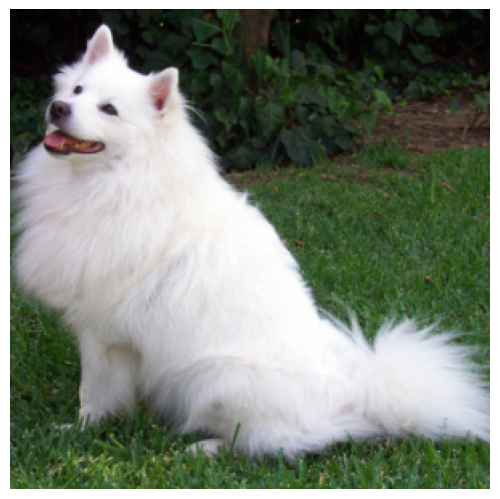

In [16]:
ShowImageNoAxis(images[0])

In [17]:
probs = predict(images)
idxs = np.argsort(-probs[0])
list(zip(probs[0][idxs[:5]], np.array(class_names)[idxs[:5]]))

[(0.5778383, 'Samoyed'),
 (0.07415329, 'Pomeranian'),
 (0.03761787, 'white wolf'),
 (0.028293198, 'keeshond'),
 (0.021155825, 'Great Pyrenees')]

In [18]:
import anchor
import anchor.anchor_image

In [20]:
import anchor
#/home/marcotcr/datasets/openimages/train contains a lot of arbitrary images - in this case, from openimages
explainer = anchor.anchor_image.AnchorImage('D:\\code\\research\\My_Anchor\\images',
                               transform_img_fn=transform_img_fn_fast, n=5000)


0


In [21]:
segments, exp = explainer.explain_instance(images[0], predict, threshold=0.95, batch_size=50,
                                            tau=0.20, verbose=True, min_shared_samples=200, beam_size=2)

True pred 258
Best: 50 (mean:1.0000000000, n: 1, lb:0.0000) Worst: 0 (mean:0.0000, n: 1, ub:1.0000) B = 1.00
Best: 49 (mean:1.0000000000, n: 1, lb:0.0000) Worst: 32 (mean:0.0000, n: 1, ub:1.0000) B = 1.00
Best: 41 (mean:1.0000000000, n: 1, lb:0.0000) Worst: 65 (mean:0.0000, n: 1, ub:1.0000) B = 1.00
Best: 34 (mean:1.0000000000, n: 1, lb:0.0000) Worst: 21 (mean:0.0000, n: 1, ub:1.0000) B = 1.00
Best: 22 (mean:1.0000000000, n: 1, lb:0.0000) Worst: 43 (mean:0.0000, n: 1, ub:1.0000) B = 1.00
Best: 19 (mean:1.0000000000, n: 1, lb:0.0000) Worst: 56 (mean:0.0000, n: 1, ub:1.0000) B = 1.00
Best: 24 (mean:1.0000000000, n: 1, lb:0.0000) Worst: 44 (mean:0.0000, n: 1, ub:1.0000) B = 1.00
Best: 63 (mean:1.0000000000, n: 1, lb:0.0000) Worst: 45 (mean:0.0000, n: 1, ub:1.0000) B = 1.00
Best: 1 (mean:1.0000000000, n: 1, lb:0.0000) Worst: 38 (mean:0.0000, n: 1, ub:1.0000) B = 1.00
Best: 3 (mean:1.0000000000, n: 1, lb:0.0000) Worst: 17 (mean:0.0000, n: 1, ub:1.0000) B = 1.00
Best: 60 (mean:1.0000000000, 

KeyboardInterrupt: 

In [22]:
exp

NameError: name 'exp' is not defined

In [23]:
def show_exp(segments, exp, image, explainer):
    mask = np.ones(segments.shape).astype(bool)
    temp = copy.deepcopy(image)
    temp_img = copy.deepcopy(temp)
#     temp.img = temp.fudged_image.copy()
    temp[:] = 0
    # for x in exp_greedy[:3]:
    #     x = (x, x)
    for x in exp:
        temp[segments == x[0]] = temp_img[segments==x[0]]
    # temp.img[mask] = np.random.random(mask.nonzero()[0].shape[0] * 3).reshape(mask.nonzero()[0].shape[0], 3)
    print ('Anchor for prediction ', class_names[predict(np.expand_dims(image, 0))[0].argmax()], 'confidence', exp[-1][2])
    ShowImageNoAxis(temp)
    print('Counter Examples:')
    for e in exp[-1][3]:
        data = e[:-1]
        temp = explainer.dummys[e[-1]].copy()
        for x in data.nonzero()[0]:
            temp[segments == x] = image[segments == x]
        ShowImageNoAxis(temp)
        print('Prediction = ', names[predict_fn(np.expand_dims(temp, 0))[0].argmax()])
show_exp(segments, exp, images[0], explainer)

NameError: name 'segments' is not defined

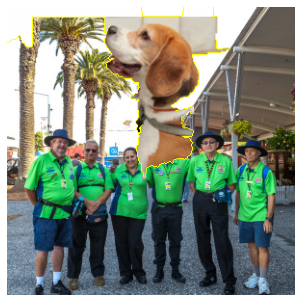

beagle 0.8532552


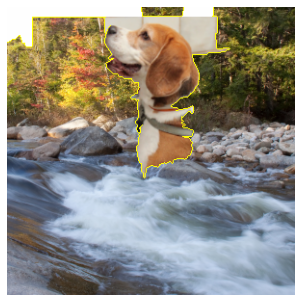

beagle 0.95835763


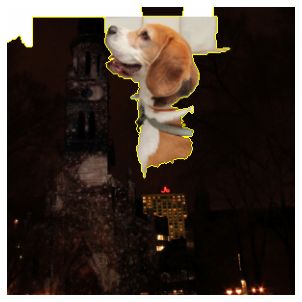

beagle 0.8676405


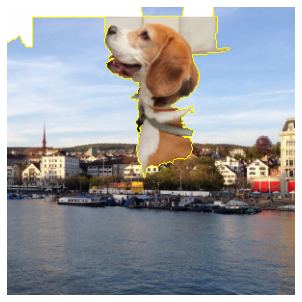

beagle 0.7541815


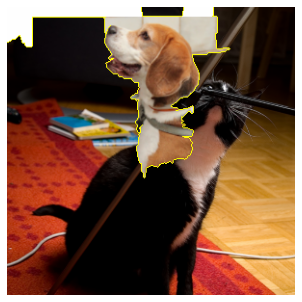

beagle 0.83341825


In [19]:
N = 5
chosen = np.random.choice(len(explainer.dummys), N)
imgs = []
masks = []
for c in chosen:
    temp = copy.deepcopy(explainer.dummys[c])
    mask = np.zeros(segments.shape).astype(bool)
    for f in exp:
        f = f[0]
        mask[segments == f] = 1
    temp[mask] = images[0][mask].copy()
    imgs.append(temp)
    masks.append(mask)
preds = predict(np.array(imgs))
for i, p in zip(imgs, preds):
#     if p.max() < 0.9:
#         continue
    ShowImageNoAxis(i, mask, '/tmp/nickz.png')
    print(class_names[p.argmax()], p.max())